# make regional weights files

In [1]:
import rhg_compute_tools.kubernetes as rhgk
import dask.distributed as dd
import dask.dataframe as ddf
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
import os
CRS_SUPPORT_BUCKET = os.environ['CRS_SUPPORT_BUCKET']

In [4]:
admin1 = gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip')

In [5]:
admin0 = gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip')

<AxesSubplot:>

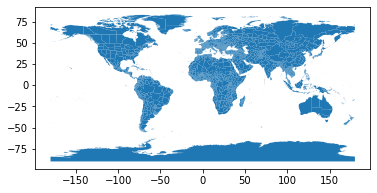

In [6]:
admin1.plot()

<AxesSubplot:>

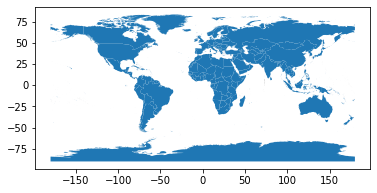

In [7]:
admin0.plot()

In [8]:
from distutils.version import LooseVersion


def get_containing_region(df, shapes, feature, x_col='x', y_col='y', crs='epsg:4326', predicate='intersects'):
    """
    Return a feature corresponding to the first polygon to contain each (x, y) point in a dataframe

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with x/y data to assign to geometries
    shapes : gpd.GeoDataFrame
        geopandas dataframe with polygon geometries
    feature : str
        column name in ``shapes`` to return for each matched feature
    x_col : str, optional
        column name in ``df`` to use for x coordinate of points (default 'x')
    y_col : str, optional
        column name in ``df`` to use for y coordinate of points (default 'y')
    crs : str, optional
        Coordinate reference system code for the projection of the (x, y) points in
        ``df``. Must be interpretable by ``pyproj``. Default ``'epsg:4326'`` (WGS 84).
    predicate : str, optional
        name of the binary predicate to use on the join. Must be a shapely binary
        predicate. See the geopandas docs on 
        `sjoin <https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html>`_.
        Default (``'intersects'``) means the first polygon in ``shapes`` to intersect
        the point (either contain or touch with boundary) will be returned.
    """
    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(df[x_col], df[y_col], crs=crs),
        index=df.index,
    )
    
    if LooseVersion(gpd.__version__) >= LooseVersion('0.10.0'):
        pred = {'predicate': predicate}
    else:
        pred = {'op': predicate}

    return gpd.sjoin(points, shapes[[feature, 'geometry']], how='left', **pred)[feature]

In [9]:
client, cluster = rhgk.get_cluster()
cluster.scale(20)
cluster

In [10]:
gpwv4_unwpp_2020 = ddf.read_parquet(
    f'gs://{CRS_SUPPORT_BUCKET}/public_datasets/spatial/exposure/GLOBAL/population/'
    'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec_tif/'
    'derived_datasets/reformatted/'
    'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec.parquet',
    chunksize='100MB',
)

POP_RASTER_WITH_REGION_ASSIGNMENTS = (
    'gs://downscaled-288ec5ac/diagnostics/rasters/'
    'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec/'
    'naturalearth_v5.0.0_adm0_and_adm1_assignments.parquet'
)

In [11]:
gpwv4_unwpp_2020

,band,y,x,population
npartitions=156,,,,
35609495,int64,float64,float64,float32
37336613,...,...,...,...
...,...,...,...,...
755840679,...,...,...,...
756791129,...,...,...,...


In [12]:
assignments_adm0 = gpwv4_unwpp_2020.map_partitions(
    get_containing_region,
    shapes=admin0[['ADM0_A3', 'geometry']],
    feature='ADM0_A3',
    meta='str',
)

In [13]:
assignments_adm0 = assignments_adm0.persist()
dd.progress(assignments_adm0, notebook=False)

In [15]:
dd.wait(assignments_adm0)
assert not any([f.status == 'error' for f in assignments_adm0.dask.values()]), assignments_adm0.compute()
gpwv4_unwpp_2020['ADM0_A3'] = assignments_adm0

In [16]:
assignments_adm1 = gpwv4_unwpp_2020.map_partitions(
    get_containing_region,
    shapes=admin1[['adm1_code', 'geometry']],
    feature='adm1_code',
    meta='str',
)

In [19]:
assignments_adm1 = assignments_adm1.persist()
dd.progress(assignments_adm1, notebook=False)

In [20]:
dd.wait(assignments_adm1)
assert not any([f.status == 'error' for f in assignments_adm1.dask.values()]), assignments_adm1.compute()
gpwv4_unwpp_2020['adm1_code'] = assignments_adm1

In [21]:
gpwv4_unwpp_2020 = gpwv4_unwpp_2020.dropna(how='all').compute()

In [22]:
gpwv4_unwpp_2020.repartition(npartitions=20).to_parquet(POP_RASTER_WITH_REGION_ASSIGNMENTS)

In [ ]:
client.restart()
cluster.scale(0)
client.close()
cluster.close()